In [1]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=1000,skip_top = 20)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

1641221/1641221 [==============================] - 0s 0us/step


In [2]:
vocabulary = list()
for text in x_train:
  tokens = text.split()
  vocabulary.extend(tokens)

vocabulary = set(vocabulary)
print(len(vocabulary))

981


In [3]:
from tqdm import tqdm

x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary)

for text in tqdm(x_test):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary)


100%|██████████| 25000/25000 [01:21<00:00, 308.23it/s]


In [4]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class AdaBoostClassifier:
    def __init__(self, T=100):
        self.T = T# amount of stumps
        self.h = []
        self.alpha = []#the alpha variables to change each weight

    def fit(self, X, y):
        n, m = X.shape# get the dimensions of the training sample 
        w = np.ones(n) / n#initilazes the weight of each sample

        for t in range(self.T):
            # Train the base classifier using the current weights
            h_t = self.fit_base_classifier(X, y, w)

            # Make predictions on the training data
            y_pred = h_t.predict(X)

            # Compute the error rate
            error = np.sum(w[y_pred != y])

            # Compute the weight for the current base classifier
            alpha_t = 0.5 * np.log((1 - error) / error)

            # Update the weights for each example
            w = w * np.exp(-alpha_t * y * y_pred)
            w = w / np.sum(w)

            # Save the current base classifier and weight
            self.h.append(h_t)
            self.alpha.append(alpha_t)

    def fit_base_classifier(self, X, y, w):
        # Fit the base classifier using the current weights
        # In this case we will use a decision tree classifier
        h_t = DecisionTreeClassifier(max_depth=1)
        h_t.fit(X, y, sample_weight=w)
        return h_t

    def predict(self, X):
        # Make predictions on new data using the ensemble of base classifiers
        n = X.shape[0]
        y_pred = np.zeros(n)
        for t in range(len(self.h)):
            y_pred += self.alpha[t] * self.h[t].predict(X)
        y_pred = np.sign(y_pred)
        return y_pred#return the array of the predictions




In [5]:
from statistics import mode
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

ada = AdaBoostClassifier()
ada.fit(x_train_binary, y_train)

# Make predictions on the test data
y_pred = ada.predict(x_test_binary)


print(classification_report(y_test,y_pred))

def custom_learning_curve(type,x_train, y_train, x_test, y_test,n_splits):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  curr_y = y_splits[0]
  ada = AdaBoostClassifier()
  ada.fit(curr_x, curr_y)

  if (type == 'accuracy'):
    train_accuracies.append(accuracy_score(curr_y,ada.predict(curr_x)))
    test_accuracies.append(accuracy_score(y_test, ada.predict(x_test)))
  elif (type == 'f1'):
    train_accuracies.append(f1_score(curr_y,ada.predict(curr_x)))
    test_accuracies.append(f1_score(y_test, ada.predict(x_test)))
  elif (type == "recall"):
    train_accuracies.append(recall_score(curr_y,ada.predict(curr_x)))
    test_accuracies.append(recall_score(y_test, ada.predict(x_test)))
  else:
    train_accuracies.append(precision_score(curr_y,ada.predict(curr_x)))
    test_accuracies.append(precision_score(y_test, ada.predict(x_test)))
    



  for i in range(1, len(x_splits)):
    ada = AdaBoostClassifier()
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    ada.fit(curr_x, curr_y)
    if (type == 'accuracy'):
      train_accuracies.append(accuracy_score(curr_y,ada.predict(curr_x)))
      test_accuracies.append(accuracy_score(y_test, ada.predict(x_test)))
    elif (type == 'f1'):
      train_accuracies.append(f1_score(curr_y,ada.predict(curr_x)))
      test_accuracies.append(f1_score(y_test, ada.predict(x_test)))
    elif (type == "recall"):
      train_accuracies.append(recall_score(curr_y,ada.predict(curr_x)))
      test_accuracies.append(recall_score(y_test, ada.predict(x_test)))
    else:
      train_accuracies.append(precision_score(curr_y,ada.predict(curr_x)))
      test_accuracies.append(precision_score(y_test, ada.predict(x_test)))


  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training"+" "+type)

  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing"+" "+type)
  plt.legend(loc="lower right")
  plt.show()

              precision    recall  f1-score   support

           0       0.75      0.35      0.48     12500
           1       0.58      0.88      0.70     12500

    accuracy                           0.62     25000
   macro avg       0.66      0.62      0.59     25000
weighted avg       0.66      0.62      0.59     25000



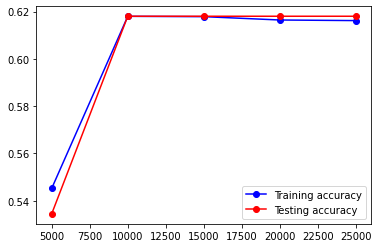

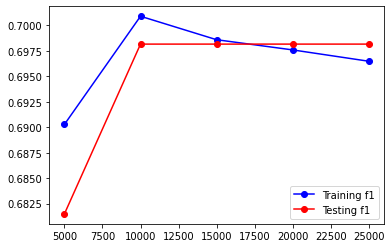

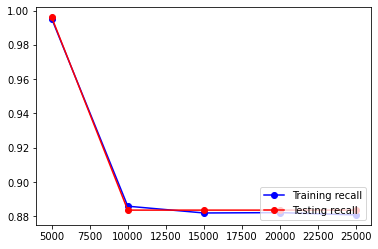

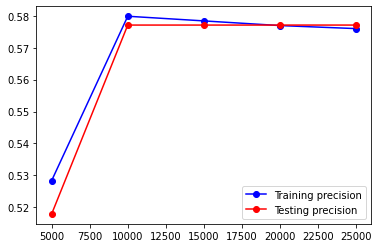

In [6]:
from sklearn.metrics import accuracy_score
custom_learning_curve('accuracy',x_train=x_train_binary, y_train=y_train,
                      x_test=x_test_binary,
                      y_test=y_test, n_splits=5)
custom_learning_curve('f1',x_train=x_train_binary, y_train=y_train,
                      x_test=x_test_binary,
                      y_test=y_test, n_splits=5)
custom_learning_curve('recall',x_train=x_train_binary, y_train=y_train,
                      x_test=x_test_binary,
                      y_test=y_test, n_splits=5)
custom_learning_curve('precision',x_train=x_train_binary, y_train=y_train,
                      x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

In [7]:
from statistics import mode
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

ada = AdaBoostClassifier()
ada.fit(x_train_binary, y_train)

# Make predictions on the test data
y_pred = ada.predict(x_test_binary)


print(classification_report(y_test,y_pred))


def custom_learning_curve(type,x_train, y_train, x_test, y_test,n_splits):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  curr_y = y_splits[0]
  ada = AdaBoostClassifier()
  ada.fit(curr_x, curr_y)

  if (type == 'accuracy'):
    train_accuracies.append(accuracy_score(curr_y,ada.predict(curr_x)))
    test_accuracies.append(accuracy_score(y_test, ada.predict(x_test)))
  elif (type == 'f1'):
    train_accuracies.append(f1_score(curr_y,ada.predict(curr_x)))
    test_accuracies.append(f1_score(y_test, ada.predict(x_test)))
  elif (type == "recall"):
    train_accuracies.append(recall_score(curr_y,ada.predict(curr_x)))
    test_accuracies.append(recall_score(y_test, ada.predict(x_test)))
  else:
    train_accuracies.append(precision_score(curr_y,ada.predict(curr_x)))
    test_accuracies.append(precision_score(y_test, ada.predict(x_test)))
    



  for i in range(1, len(x_splits)):
    ada = AdaBoostClassifier()
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    ada.fit(curr_x, curr_y)
    if (type == 'accuracy'):
      train_accuracies.append(accuracy_score(curr_y,ada.predict(curr_x)))
      test_accuracies.append(accuracy_score(y_test, ada.predict(x_test)))
    elif (type == 'f1'):
      train_accuracies.append(f1_score(curr_y,ada.predict(curr_x)))
      test_accuracies.append(f1_score(y_test, ada.predict(x_test)))
    elif (type == "recall"):
      train_accuracies.append(recall_score(curr_y,ada.predict(curr_x)))
      test_accuracies.append(recall_score(y_test, ada.predict(x_test)))
    else:
      train_accuracies.append(precision_score(curr_y,ada.predict(curr_x)))
      test_accuracies.append(precision_score(y_test, ada.predict(x_test)))


  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training"+" "+type)

  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing"+" "+type)
  plt.legend(loc="lower right")
  plt.show()

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     12500
           1       0.79      0.84      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



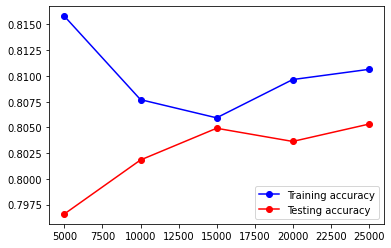

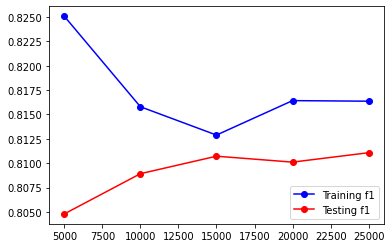

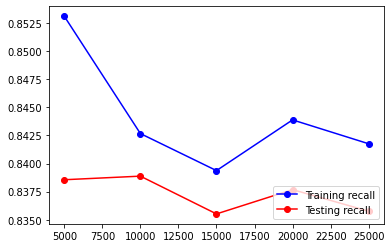

In [ ]:
from sklearn.metrics import accuracy_score
custom_learning_curve('accuracy',x_train=x_train_binary, y_train=y_train,
                      x_test=x_test_binary,
                      y_test=y_test, n_splits=5)
custom_learning_curve('f1',x_train=x_train_binary, y_train=y_train,
                      x_test=x_test_binary,
                      y_test=y_test, n_splits=5)
custom_learning_curve('recall',x_train=x_train_binary, y_train=y_train,
                      x_test=x_test_binary,
                      y_test=y_test, n_splits=5)
custom_learning_curve('precision',x_train=x_train_binary, y_train=y_train,
                      x_test=x_test_binary,
                      y_test=y_test, n_splits=5)